# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Data Preperation

### Load Dataset

In [2]:
# Import dataset
dataset = pd.read_csv("./data/train.csv")

### Visualize Dataset

In [3]:
import matplotlib.pyplot as plt

def print_rand(data:pd.core.frame.DataFrame , number_of_sample:int):
    for i in range(number_of_sample):
        n = np.random.randint(0,high=len(data))
        print('MNIST database example digit: ', data['label'][n])
        im = data.drop(['label'], axis=1).iloc[n].to_numpy()/255
        plt.imshow(im.reshape(28,28))
        plt.show()

In [4]:
print(dataset.shape)
print(len(dataset))

(42000, 785)
42000


MNIST database example digit:  6


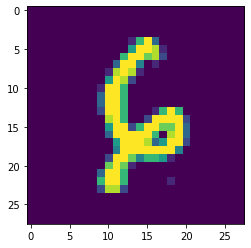

MNIST database example digit:  2


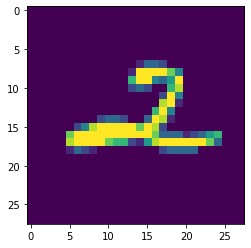

MNIST database example digit:  0


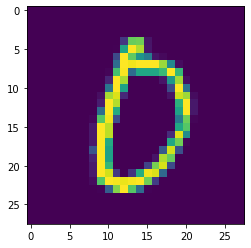

In [5]:
print_rand(dataset,3)

### Preprocess the dataset

In [6]:
from sklearn.model_selection import train_test_split

# divide preliminary dataset set into features and labels
X = dataset.drop(columns=["label"])/255. # features
y = dataset['label'] # labels

### Check Class distribution

{1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795}


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


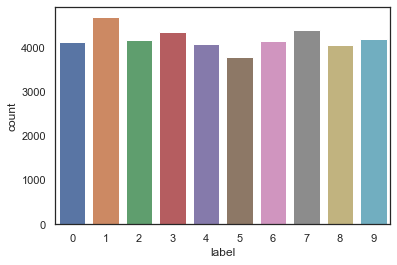

In [7]:
import seaborn as sns

sns.set(style='white', context='notebook', palette='deep')
# check whether class distribution is inbalanced in order to decide whether to use k-fold or stratified
print(dict(y.value_counts()))
g = sns.countplot(y)

### Check for null and missing values

In [8]:
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
y.isnull().any()

False

### From Grayscale to RGB

In [10]:
dataset.shape

(42000, 785)

In [11]:
def grey_to_RGB(data:pd.core.frame.DataFrame, IMG_RES:int):
    dim = np.zeros((IMG_RES,IMG_RES)) # Dimension Array
    X_RGB = [] # Empty list to save RGB images 
    X_temp = data.drop(columns=["label"])
    for i in range(X.shape[0]):
        im = X_temp.iloc[i].to_numpy() # fetch image
        im = im.reshape(IMG_RES,IMG_RES) # Reshape the image
        R = np.stack((im,dim,dim),axis=2) # Add Red Dimension
        G = np.stack((dim,im,dim),axis=2) # Add Green Dimension
        B = np.stack((dim,dim,im),axis=2) # Add Blue Dimension
        X_RGB.append(R+G+B)
    return X_RGB # Returns the List of Images

In [21]:
# Convert 1D Image to RGB
X_RGB = grey_to_RGB(dataset,28)

In [13]:
print(X_RGB[0].shape)
print(type(X_RGB[0]))
print(len(X_RGB))

(28, 28, 3)
<class 'numpy.ndarray'>
42000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


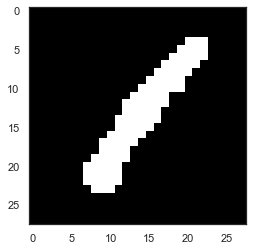

In [14]:
plt.imshow(X_RGB[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


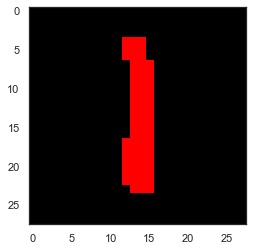

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


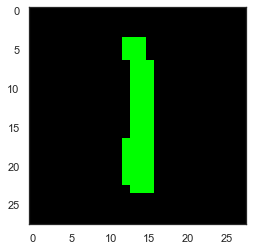

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


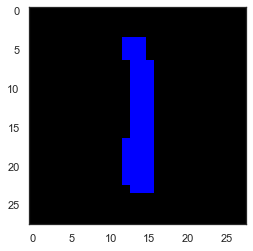

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(28, 28, 3)
<class 'numpy.ndarray'>


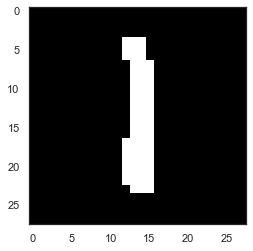

In [15]:
im = dataset.drop(['label'], axis=1).iloc[1000].to_numpy()
dim = np.zeros((28,28))
im = im.reshape(28,28)

R = np.stack((im,dim,dim),axis=2)
plt.imshow(R)
plt.show()
G = np.stack((dim,im,dim),axis=2)
plt.imshow(G)
plt.show()
B = np.stack((dim,dim,im),axis=2)
plt.imshow(B)
plt.show()
print(R.shape)
G = R+G+B
print(type(G))
plt.imshow(R+G+B)
plt.show()

### Reshape the Dataset

In [17]:
def format_image(images:list, IMAGE_RES:int):
    reshaped_images = []
    for image in images:
        image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))
        #image = tf.convert_to_tensor(image) # Convert Image to Tensor Object
        reshaped_images.append(image)
    return reshaped_images

In [28]:
# Resize RGB Images from 28x28 to 224x224
IMAGE_RES = 224
X_RGB = format_image(X_RGB,IMAGE_RES)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>


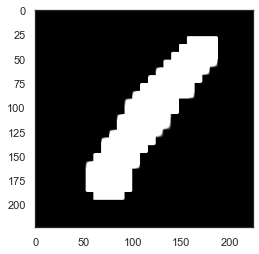

In [29]:
print(X_RGB[0].shape)
print(type(X_RGB[0]))
plt.imshow(X_RGB[0])
plt.show()

In [38]:
type(dataset["label"][0])

numpy.int64

In [40]:
# Export Images in .png 

#from PIL import Image

#for i in range(len(X_RGB)):
    #base_dir="./Images/"
    #path = str(dataset["label"][i])+"/"+ str(i)+".png"
    #tf.keras.preprocessing.image.save_img(base_dir+path,X_RGB[i])

In [30]:
print(len(X_RGB))
print("Shape of X_RGB is: ",X_RGB[0].shape)
print(len(y))

42000
Shape of X_RGB is:  (224, 224, 3)
42000


In [36]:
# split the dataset into Training and Test setsX_RGB 
X_train, X_test, y_train, y_test = train_test_split(X_RGB,y,test_size=0.5, stratify=y) # 80 to 20% randomly

In [37]:
len(X_train)

21000

In [39]:
X_train[0].shape

TensorShape([224, 224, 3])

In [ ]:
# Split the train and the validation set for the fitting
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=112) # 90 to 10%

# Modelling

### Import the Pre-Trained Model

### Setup the Layers

In [33]:
import tensorflow_hub as hub

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                    output_shape=[1280], trainable=False),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.build([None, 224, 224, 3])  # Batch input shape.

### Set the model parameters

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [35]:
EPOCHS = 1 
BATCH_SIZE = 50

### Train the model

In [38]:
from math import ceil
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS,
                    shuffle=False,
                    batch_size=BATCH_SIZE
                    )

ValueError: Data cardinality is ambiguous:
  x sizes: 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224
  y sizes: 21000
Make sure all arrays contain the same number of samples.

### Evaluate the model

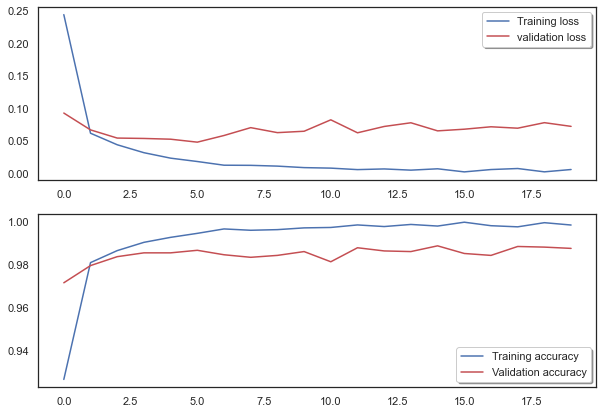

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
results = model.predict(X_test)

print(results.shape)

print(results[-1].argmax())
print(type(results[-1].argmax()))

print(y_test.shape[0])
print(y_test.iloc[-1])
print(type(y_test.iloc[-1]))
print(type(y_test))

263/263 [==============================] - 1s 5ms/step
(8400, 10)
1
<class 'numpy.int64'>
8400
1
<class 'numpy.int64'>
<class 'pandas.core.series.Series'>


### Predict the results

In [ ]:
y_predict = model.predict(X_test)

263/263 [==============================] - 1s 5ms/step


### Evaluate the test accuracy

In [ ]:
def acc_model(y_test, y_predict):
    if y_test.shape[0] != y_predict.shape[0]:
        print("Invalid Input, size of the arrays do not match!")
        return 0
    else:
        sum=0
        for i in range(y_test.shape[0]):
            if y_test.iloc[i] == y_predict[i].argmax():
                sum += 1
    return float("%.4f" % (sum/y_test.shape[0]))

In [ ]:
accuracy = acc_model(y_test,y_predict)
accuracy

0.9885